**Tunning dos hiperparâmetros**
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

**Workflow:**
Para cada caso:
1. Importar dados
2. Separar em treino, teste e validação.
3. Definir os parâmetros a serem testados
4. Realizar o tunning
5. Salvar os resultados graficamente
6. Salvar o melhor modelo
7. Aplicar o Random Under-Sampling no treino (Voltar para o passo 3).


## SETUP
(Executar apenas uma vez)

In [1]:
# Instalando bibliotecas
!pip install -U pandas
!pip install -U numpy
!pip install -U scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install -U xgboost
!pip install -U mlxtend
!pip install -U joblib
!pip install -U seaborn
!pip install -U matplotlib


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------- ---------------------------- 0.4/1.4 MB 6.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.23.0
    Uninstalling mlxtend-0.23.0:
      Successfully uninstalled mlxtend-0.23.0


## Inicialização
(Executar sempre que reiniciar o kernel)

### Importando as bibliotecas

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier
import pickle
import time
import multiprocessing
n_cpus = multiprocessing.cpu_count()
from sklearn.model_selection import RandomizedSearchCV

# import warnings
# warnings.filterwarnings('ignore')

np.random.seed(15) # Para reproduzir os resultados

### Definindo a função

In [4]:
def plot_model_performance(model_accuracies, base_name):
    # Create a DataFrame with the results
    df_resultado = pd.DataFrame({'Modelo': list(model_accuracies.keys()), 'Acurácia': list(model_accuracies.values())})

    # Sort the DataFrame by accuracy
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Random Forest': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGBoost': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plot the bar chart, which ranges from 0 to 1
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Add values on the bars
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.title('Desempenho dos modelos')
    plt.tight_layout()
    plt.show()


In [5]:
def perform_random_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and y_train is not None:
        X_train = x_train
        y_train = y_train
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"\nTuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']
        
        print("Paramêtros sendo testados:")
        #Imprime os parametros que serão testados
        for param in param_grid.keys():
            print(f"{param} | {param_grid[param]}")

        try:
            # Realizar a busca aleatória para encontrar os melhores parâmetros
            grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=True, n_jobs=n_cpus, n_iter=100, random_state=13, error_score='raise')

            # Iniciar a contagem do tempo
            start = time.time()

            grid_search.fit(X_train, y_train)

            # Finalizar a contagem do tempo
            end = time.time()

                        
            # cv_results = grid_search.cv_results_
            # best_index = grid_search.best_index_
            # best_f1_weighted = cv_results['mean_test_f1_weighted'][best_index]
            # print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name} | Acurácia: {grid_search.best_score_} | F1: {best_f1_weighted}")
            
            print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name} | Acurácia: {grid_search.best_score_}")
            # Melhor modelo encontrado
            best_model = grid_search.best_estimator_

            # Calcular a acurácia do modelo
            accuracy = grid_search.best_score_
            model_accuracies[model_name] = accuracy



            # Imprimir parâmetros selecionados do modelo
            print(f"Parâmetros selecionados: {grid_search.best_params_}")

            # Salvar o melhor modelo
            best_models[model_name] = best_model

        except Exception as e:
            print(f"Modelo {model_name} não convergiu. Detalhes: {str(e)}")

    #Imprime a acuracia de cada modelo e o seu respectivo nome
    for model_name in model_accuracies.keys():
        print(f"\nModelo: {model_name} | Acurácia: {model_accuracies[model_name]}")

    # # Plotar gráfico de desempenho comparativo
    plot_model_performance(model_accuracies, base_name)

    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))

    # Salvar tabela com NOME DO MODELO, ACURÁCIA, PARAMETROS
    table_filename = f"{base_name}_acuracy.csv"
    results_df = pd.DataFrame(columns=['Modelo', 'Acurácia', 'Parâmetros'])

    # #Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    # for model_name in model_accuracies.keys():
    #     results_df.append([model_name, model_accuracies[model_name], best_models[model_name].get_params()])

    # Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    for model_name in model_accuracies.keys():
        row = {'Modelo': model_name, 'Acurácia': model_accuracies[model_name], 'Parâmetros': best_models[model_name].get_params()}
        results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

    table_path = os.path.join(current_dir, table_filename)
    #Ordena os resultados pela acuracia
    results_df.sort_values(by=['Acurácia'], ascending=False)
    results_df.to_csv(table_path, index=False)



    # # Salvar tabela com os valores de acurácia
    # table_filename = f"{base_name}_acuracy.csv"
    # accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    # table_path = os.path.join(current_dir, table_filename)
    # accuracies_df.to_csv(table_path, index=False)

    return best_models, best_model

In [6]:
def perform_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None, x_test=None,  y_test=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and x_test is not None and y_train is not None and y_test is not None:
        X_train = x_train
        X_test = x_test
        y_train = y_train
        y_test = y_test
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"\nTuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']
        
        print("Paramêtros sendo testados:")
        #Imprime os parametros que serão testados
        for param in param_grid.keys():
            print(f"{param} | {param_grid[param]}")

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=True, n_jobs=n_cpus, error_score='raise')
        
        # Iniciar a contagem do tempo
        start = time.time()
        
        grid_search.fit(X_train, y_train)
        
        # Finalizar a contagem do tempo
        end = time.time()
        print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name}")
        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # # Fazer previsões no conjunto de teste
        # y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        # accuracy = accuracy_score(y_test, y_pred)
        accuracy = grid_search.best_score_
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        #Imprimindo parametros selecionados do modelo
        print(f"Parâmetros selecionados: {grid_search.best_params_}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    

    #Imprime a acuracia de cada modelo e o seu respectivo nome
    for model_name in model_accuracies.keys():
        print(f"\nModelo: {model_name} | Acurácia: {model_accuracies[model_name]}")


    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))

    # Salvar tabela com NOME DO MODELO, ACURÁCIA, PARAMETROS
    table_filename = f"{base_name}_acuracy.csv"
    results_df = pd.Dataframe(collumns=['Modelo', 'Acurácia', 'Parâmetros'])

    #Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    for model_name in model_accuracies.keys():
        results_df.append([model_name, model_accuracies[model_name], best_models[model_name].get_params()])

    table_path = os.path.join(current_dir, table_filename)
    #Ordena os resultados pela acuracia
    results_df.sort_values(by=['Acurácia'], ascending=False)
    results_df.to_csv(table_path, index=False)



    # # Salvar tabela com os valores de acurácia
    # table_filename = f"{base_name}_acuracy.csv"
    # accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    # table_path = os.path.join(current_dir, table_filename)
    # accuracies_df.to_csv(table_path, index=False)

    return best_models

In [7]:
def ler_arquivo_txt(nome_arquivo):
    with open(nome_arquivo, 'r') as arquivo:
        vetor_strings = []
        for linha in arquivo:
            valores = linha.strip().replace('(', '').replace(')', '').replace("'", '').split(', ')
            vetor_strings.append(valores)
    return vetor_strings

In [8]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n, shuffle=True, random_state=13)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent',random_state=13)
    rf_av = RandomForestClassifier(n_jobs=n_cpus, random_state=13)
    svm_av = SVC(random_state=23, max_iter=-1)
    mlp_av = MLPClassifier(max_iter=2000,random_state=13)
    xgb_av = XGBClassifier(n_jobs=n_cpus, random_state=13)
    knn_av = KNeighborsClassifier(n_jobs=n_cpus)
    ada_av = AdaBoostClassifier(random_state=13)
    nvb_av = GaussianNB()
    lr_av = LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000)
    dt_av = DecisionTreeClassifier(random_state=13)
    ext_av = ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
    

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    #Passa de numpy para cupy
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)
    knn_fun_av = avalia_modelo_cv(knn_av, X_train, y_test, cv)
    ada_fun_av = avalia_modelo_cv(ada_av, X_train, y_test, cv)
    nvb_fun_av = avalia_modelo_cv(nvb_av, X_train, y_test, cv)
    lr_fun_av = avalia_modelo_cv(lr_av, X_train, y_test, cv)
    dt_fun_av = avalia_modelo_cv(dt_av, X_train, y_test, cv)
    ext_fun_av = avalia_modelo_cv(ext_av, X_train, y_test, cv)
    

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB', 'KNN', 'ADA', 'NVB', 'LR', 'DT', 'EXT'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av, knn_fun_av, ada_fun_av, nvb_fun_av, lr_fun_av, dt_fun_av, ext_fun_av]})


    # Ordenando o dataframe pela acurácia
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Dummy': 'gray',
        'RF': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGB': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plotando o gráfico de barras, que vai de 0 a 1
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Adicionando os valores nas barras
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.show("Desempenho dos modelos")
    #%matplotlib inline

    return df_resultado

In [9]:
# def perform_cross_validation(model, X, y, cv, verbose=True):
#     reports = []
#     predictions = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

#     for fold in range(cv):
#         start = fold * len(X) // cv
#         end = (fold + 1) * len(X) // cv
#         report = classification_report(y[start:end], predictions[start:end], output_dict=True)
#         reports.append(report)

#         if verbose:
#             print(f"Fold {fold + 1} Classification Report:")
#             print(classification_report(y[start:end], predictions[start:end]))
#             print("-" * 50)

#     avg_report = {
#         'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
#         'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
#         'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
#         'support': np.mean([report['weighted avg']['support'] for report in reports])
#     }

#     accuracy = accuracy_score(y, predictions)

#     if verbose or not verbose:
#         print("Average Classification Report:")
#         print(classification_report(y, predictions))
#         print("-" * 50)
#         print(f"Accuracy: {accuracy:.8f}")

#     return None


# from sklearn.model_selection import cross_validate
# from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

# def perform_cross_validation(model, X, y, cv, verbose=True):
#     scoring = {
#         'precision': make_scorer(precision_score, average='weighted'),
#         'recall': make_scorer(recall_score, average='weighted'),
#         'f1_score': make_scorer(f1_score, average='weighted'),
#         'accuracy': make_scorer(accuracy_score)
#     }

#     scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

#     if verbose:
#         print("Cross Validation Scores:")
#         for metric, values in scores.items():
#             print(f"{metric}: {values.mean():.4f} (+/- {values.std() * 2:.4f})")

#     return scores


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_validate
import numpy as np

def perform_cross_validation(model, X, y, cv, verbose=True):
    scores = cross_validate(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=False)

    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average=None)

    if verbose:
        print("Cross Validation Scores:")
        print(f"Accuracy: {scores['test_score'].mean():.4f} (+/- {scores['test_score'].std() * 2:.4f})")

        for i, (prec, rec, f1_, support) in enumerate(zip(precision, recall, f1, np.unique(y))):
            print(f"Class {int(support)} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_:.4f}")

    return scores


In [10]:
# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    n_cpus = multiprocessing.cpu_count()
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [11]:
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
        if modelo.get_params()['device'] == 'cuda':
            modelo.device = 'gpu'
            print(modelo)
    except:
        pass


### Importando os dados

In [15]:
# Sem WHOQOL:
base1 = pd.read_csv('/home/apo-pc/Documents/GitHub/Classificacao_MHI_BIC/Codigos-Desenvolvimento/Datasets/dataframe_socioeconomico_Niveis.csv')
data1 = base1.drop('Nivel_MHI', axis=1)
target1 = base1['Nivel_MHI']
le = LabelEncoder()
target1 = le.fit_transform(target1)

# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.2, random_state=13, stratify=target1)

In [16]:
# Com todas as respostas do WHOQOL
base2 = pd.read_csv('/home/apo-pc/Documents/GitHub/Classificacao_MHI_BIC/Codigos-Desenvolvimento/Datasets/df_social_whoqol_tratado_1.csv')
data2 = base2.drop('Nivel_MHI', axis=1)
target2 = base2['Nivel_MHI']
target2 = le.fit_transform(target2)

# Dividir os dados em treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=13, stratify=target2)


## Analise exploratória dos dados
- Ver numero de linhas e colunas de cada base, com e sem Random Under-Sampling. 
- Ver como ficou divisão de treino e teste.
- Ver como ficou a divisão de treino e validação.
- Ver como ficou a divisão de treino e teste com o Random Under-Sampling.

### Verificando o tamanho das bases

In [21]:
# Verificando o tamanho das bases 
print("Tamanho das bases:")
print(f"Base 1: {data1.shape}")
print(f"Base 2: {data2.shape}")


Tamanho das bases:
Base 1: (872, 54)
Base 2: (872, 84)


In [22]:
# Verificando o tamanho das bases de treino e teste
print("Tamanho das bases de treino e teste:")
print(f"Base 1: {X_train1.shape}, {X_test1.shape}")
print(f"Base 2: {X_train2.shape}, {X_test2.shape}")

Tamanho das bases de treino e teste:
Base 1: (697, 54), (175, 54)
Base 2: (697, 84), (175, 84)


### Verificando a distribuição das classes

In [24]:
# Verificando a distribuição das classes
print("Distribuição das classes:")
print(f"Base 1: {np.unique(target1, return_counts=True)}")
print(f"Base 2: {np.unique(target2, return_counts=True)}")

Distribuição das classes:
Base 1: (array([0, 1, 2]), array([149, 149, 574]))
Base 2: (array([0, 1, 2]), array([149, 149, 574]))


## Avaliando modelos sem Under-Sampling

### Base 1 - Sem WHOQOL

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.05       119
           1       0.10      0.01      0.02       119
           2       0.65      0.97      0.78       459

    accuracy                           0.64       697
   macro avg       0.36      0.33      0.28       697
weighted avg       0.51      0.64      0.52       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


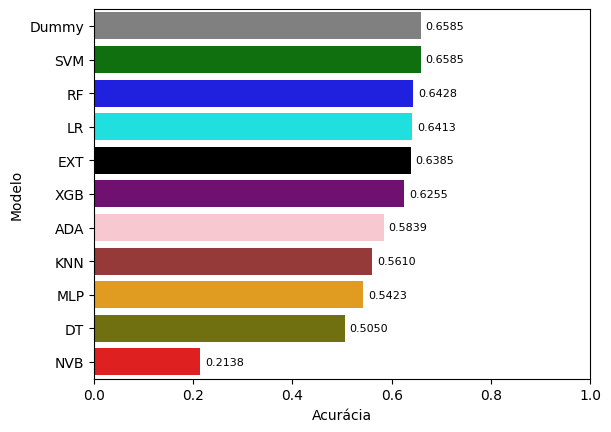

,Modelo,Acurácia
0,Dummy,0.658537
2,SVM,0.658537
1,RF,0.642755
8,LR,0.641320
10,EXT,0.638451
4,XGB,0.625538
6,ADA,0.583931
5,KNN,0.560976
3,MLP,0.542324
9,DT,0.505022


In [49]:
avalia_dif_modelos_cv(X_train1, y_train1, 5)

### Base 2 - Com WHOQOL Completo

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.50      0.61       119
           1       0.83      0.60      0.69       119
           2       0.80      0.93      0.86       459

    accuracy                           0.80       697
   macro avg       0.80      0.68      0.72       697
weighted avg       0.80      0.80      0.79       697

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       119
           1       0.88      0.35      0.50       119
           2       0.70      0.99      0.82       459

    accuracy                           0.71       697
   macro avg       0.86      0.45      0.45       697
weighted avg       0.78      0.71      0.63       697

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


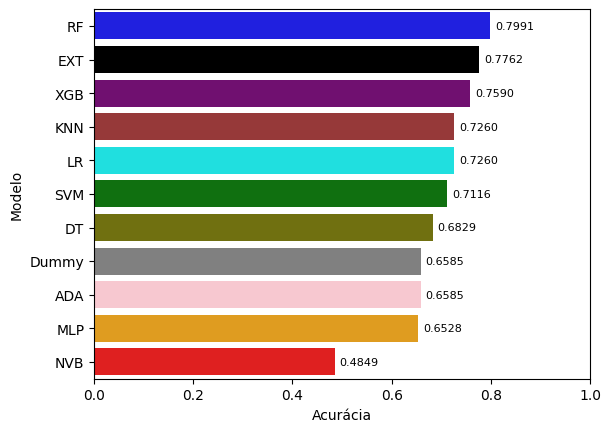

,Modelo,Acurácia
1,RF,0.799139
10,EXT,0.776184
4,XGB,0.758967
5,KNN,0.725968
8,LR,0.725968
2,SVM,0.711621
9,DT,0.682927
0,Dummy,0.658537
6,ADA,0.658537
3,MLP,0.652798


In [50]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

## Tunning dos hiperparâmetros GridSearch

### Parametros para grid search

In [24]:
def get_param_grid(X,y):
    import math
    param_grids = [
        {
            'model': 'Random Forest',
            'params': {
                # Vetor linear inteiro, entre log2(numero_de_classes) e numero_de_features/2
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                # Vetor linear inteiro, de ln(numero de objetos no conjunto) -40 até ln(numero de objetos no conjunto) + 45
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                # Vetor linear inteiro, numero features * 0.3 até numero features * 0.8
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 20, dtype=int)),
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        },
        {
            #  C=2^−5,2^−3,…,2^15;γ=2^−15,2^−13,…,2^3
            'model': 'SVM',
            'params': {
                # 'C': np.linspace(2**-5, 2**15, 10),
                # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                # 'gamma': np.linspace(2**-15, 2**3, 10),
                'C': [0.00001, 0.0001, 0.001,  0.01, 0.1, 1, 10, 100, 1000, 10000],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 'scale', 1/len(X.columns)],
                'degree': np.linspace(2, 6, 6, dtype=int)
            }
        },
        {
            'model': 'MLP',
            'params': {
                'hidden_layer_sizes': [(neurons,) * layers for layers in range(1, 4) for neurons in range(len(X.columns) * 5, len(X.columns) * 10 + 1)],
                'learning_rate_init': np.linspace(0.0001, 1, 10),
                'momentum': np.linspace(0.1, 0.9, 10),
                'max_iter': np.linspace(400, 4000, 20, dtype=int)
            }
        },
        {
            'model': 'XGBoost',
            'params': {
                # Segue o mesmo padrão do Random Forest
                'max_depth': np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int),
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                'learning_rate': np.linspace(0.0001, 1, 10),
                'subsample': np.linspace(0.1, 1, 10),
                'gamma': np.linspace(0, 1, 10),
                'colsample_bytree': np.linspace(0.5, 1, 10)
            }
        },
        {
                'model': 'KNN',
                'params': {
                    'n_neighbors': np.linspace(1, 30, 15, dtype=int),
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'p': [1, 2, 3, 4],
                    'leaf_size': np.linspace(1, 100, 20, dtype=int)
                }
        },
        {
            'model': 'ADA',
            'params': {
                'n_estimators': np.linspace(50, 500, 30, dtype=int),
                'learning_rate': np.linspace(0.001, 1, 30),
                'algorithm': ['SAMME', 'SAMME.R']
            }
        },
        {
            'model': 'NVB',
            'params': {
                'var_smoothing': np.linspace(1e-10, 1e1, 60)
            }
        },
        {
            'model': 'LR',
            'params': {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'C': np.linspace(0.001, 1, 15),
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter': np.linspace(100, 2000, 15, dtype=int)
            }
        },
        {
            'model': 'DT',
            'params': {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                'min_samples_split': np.linspace(0.01, 1, 20),
                'min_samples_leaf': np.linspace(0.01, 0.5, 20)
            }
        },
        {
            'model': 'EXT',
            'params': {
                # Segue o mesmo padrão do Random Forest
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 15, dtype=int)),
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 15, dtype=int),1)),
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 15, dtype=int)),
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        }

    ]


        # Create a list of solver-penalty pairs that are compatible
    compatible_solver_penalty = [
        ('newton-cg', 'l2'),
        ('lbfgs', 'l2'),
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('sag', 'l2'),
        ('saga', 'l1'),
        ('saga', 'l2'),
        ('saga', 'elasticnet'),
        ('newton-cg', 'none'),
        ('lbfgs', 'none'),
        ('sag', 'none'),
        ('saga', 'none')
    ]

    # Modify the 'LR' dictionary in your param_grid
    for grid in param_grids:
        if grid['model'] == 'LR':
            grid['params']['penalty'] = [penalty for penalty in grid['params']['penalty'] if ('saga', penalty) in compatible_solver_penalty]
            grid['params']['solver'] = [solver for solver in grid['params']['solver'] if (solver, 'elasticnet') in compatible_solver_penalty]
            if 'elasticnet' in grid['params']['penalty']:
                grid['params']['l1_ratio'] = np.linspace(0, 1, 10)
    return param_grids

#### A

In [25]:
#Definindo parametros:
#Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(n_jobs=n_cpus, random_state=13),
    'SVM': SVC(random_state=13),
    'MLP': MLPClassifier(random_state=13),
    'XGBoost': XGBClassifier(n_jobs=n_cpus, random_state=13),
    'KNN': KNeighborsClassifier(n_jobs=n_cpus),
    'ADA': AdaBoostClassifier(random_state=13),
    'NVB': GaussianNB(),
    'LR': LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000),
    'DT': DecisionTreeClassifier(random_state=13),
    'EXT': ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [2, 5, 10, 15, 20 ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    },
    {
        #  C=2^−5,2^−3,…,2^15;γ=2^−15,2^−13,…,2^3
        # 'model': 'SVM',
        # 'params': {
        #     'C': [2**i for i in range(-5, 16, 2)],
        #     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'gamma': [2**i for i in range(-15, 4, 2)] + ['scale', 'auto'],
        #     'degree': np.linspace(2, 6, 4, dtype=int)
        # }

        'model': 'SVM',
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11, 13, 15, ],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'KNN',
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [5,10, 20, 30, 40, 50],
            'p': [1, 2, 3, 4, 5, 6]
        }
    }
    ,
    {
        'model': 'ADA',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
    ,
    {
        'model': 'NVB',
        'params': {
            'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
        }
    }
    ,
    {
        'model': 'LR',
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 300, 400, 500],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'DT',
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
    ,
    {
        'model': 'EXT',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    }
]

### Tunning dos modelos sem Random Under-Sampling

#### Base 1 - Sem WHOQOL

========================== Data 1  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 5.62s | Modelo: Random Forest | Acurácia: 0.680453667953668
Parâmetros selecionados: {'n_estimators': 42, 'max_features': 24, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 18.68s | Modelo: LR | Acurácia: 0.675
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1864, 'l1_ratio': 0.3333333333333333, 'C': 0.42914285714285716}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.24s | Modelo: DT | Acurácia: 0.666071

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


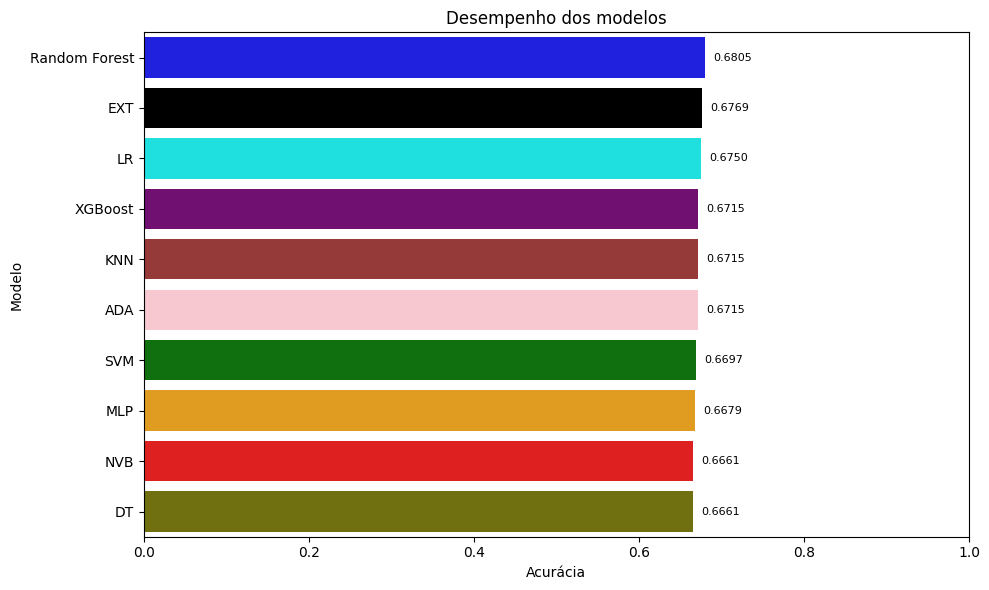



Melhor modelo: Random Forest | Acurácia: 0.680453667953668

Tempo de execução total :1953.49s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [119]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1_Desb, best1_desb = perform_random_model_tuning(models, get_param_grid(X_train1, y_train1), "data1_desb", X_train1, y_train1)

#### Base 2 - Com WHOQOL Completo

========================== Data 2  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [25 27 29 31 33 36 38 40 42 44 47 49 51 53 55 58 60 62 64 67]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 4.22s | Modelo: Random Forest | Acurácia: 0.7935649935649935
Parâmetros selecionados: {'n_estimators': 51, 'max_features': 29, 'max_depth': 39, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.011904761904761904]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 665.38s | Modelo: SVM | Acurácia: 0.7666344916344916
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 1e-05, 'degree': 2, 'C': 1000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(420,), (421,), (422,), (423,), (424,), (425,), (426,), (427,), (428,), (429,), (430,), (431,), (432,), (433,), (434,), (435,), (436,), (437,), (438,), (439,), (440,), (441,), (442,), (443,), (444,), (445,), (446,), (447,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (589) reached and the optimization hasn't converged yet.
  warnings.warn(


Tempo de execução: 1706.10s | Modelo: MLP | Acurácia: 0.7271396396396396
Parâmetros selecionados: {'momentum': 0.8111111111111111, 'max_iter': 589, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (541,)}

Tuning do modelo XGBoost iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
learning_rate | [1.000e-04 1.112e-01 2.223e-01 3.334e-01 4.445e-01 5.556e-01 6.667e-01
 7.778e-01 8.889e-01 1.000e+00]
subsample | [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
gamma | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
colsample_bytree | [0.5        0.55555556 0.61111111 0.66666667 0.72222222 0.77777778
 0.83333333 0.88888889 0.94444444 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 10.29s | Modelo: XGBoost | Acurácia: 0.7899131274131272
Parâmetros selecionados: {'subsam

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 28.03s | Modelo: LR | Acurácia: 0.7486969111969112
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1728, 'l1_ratio': 1.0, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.33s | Modelo: DT | Acurácia: 0.777413127

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


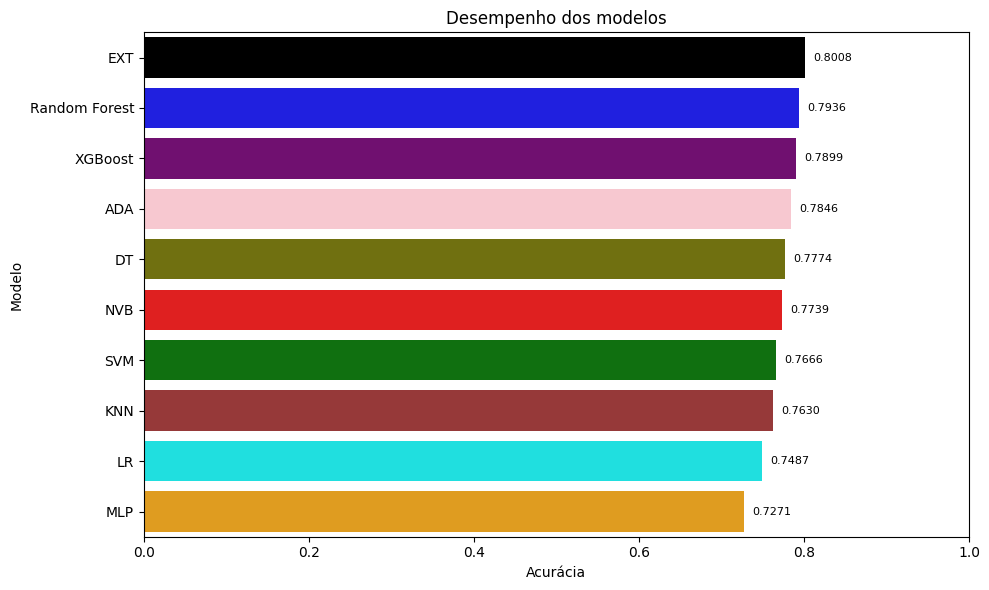



Melhor modelo: EXT | Acurácia: 0.8007561132561133

Tempo de execução total :2441.08s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [120]:
print("========================== Data 2  =================================")
best_models3Desb, best2_desb = perform_random_model_tuning(models, get_param_grid(X_train2, y_train2), "data2_desb", X_train2, y_train2)

## Feature Selection

In [59]:
updt_maxfeature(modelo1_desb)
updt_maxfeature(modelo2_desb)

### Aplicando SBFS e SFFS

#### Feature Selection nas bases sem Random Under-Sampling

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    8.6s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    8.8s finished

[2023-12-26 13:25:59] Features: 53/1 -- score: 0.6657348406988695[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    7.6s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    7.8s finished

[2023-12-26 13:26:07] Features: 52/1 -- score: 0.6642857142857143[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    6.7s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    6.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    4.5s finished

[2023-12-26 13:34:51] Features: 1/54 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.7s finished

[2023-12-26 13:34:53] Features: 2/54 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.5s finish

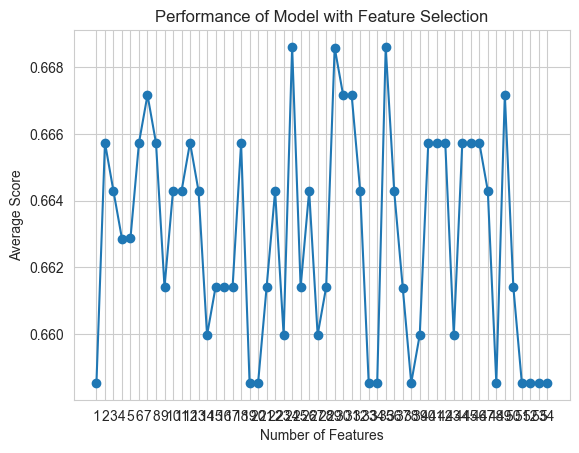

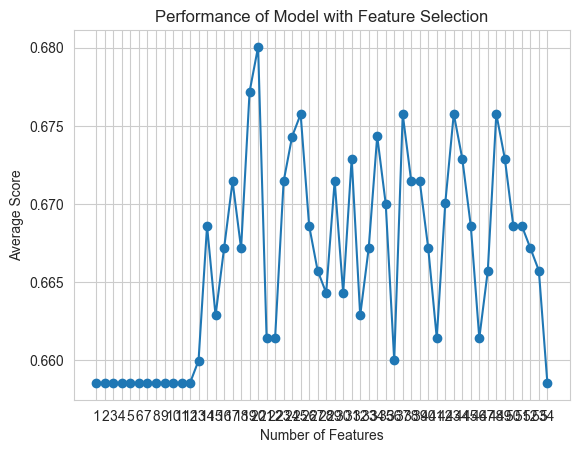

In [32]:
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1_desb, score1_sbfs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features1_desb, score1_sffs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SFFS', 5)

========================== Data 2  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    7.1s finished

[2024-01-15 15:49:31] Features: 83/1 -- score: 0.7991675231243577[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    5.6s finished

[2024-01-15 15:49:37] Features: 82/1 -- score: 0.7920143884892086[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s finished

[2024-01-15 15:49:44] Features: 81/1 -- score: 0.7977286742034945[Parallel(n_jobs=16)]: Usin

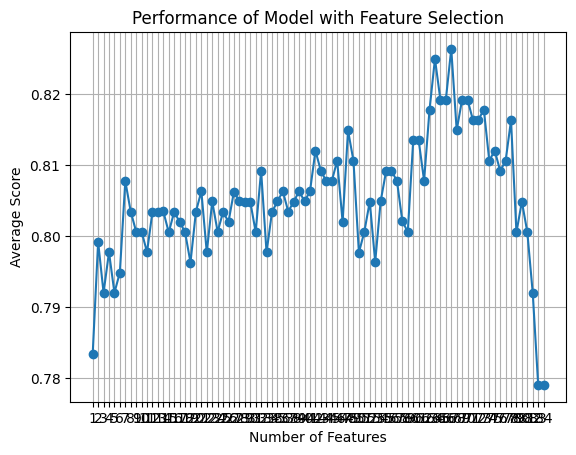

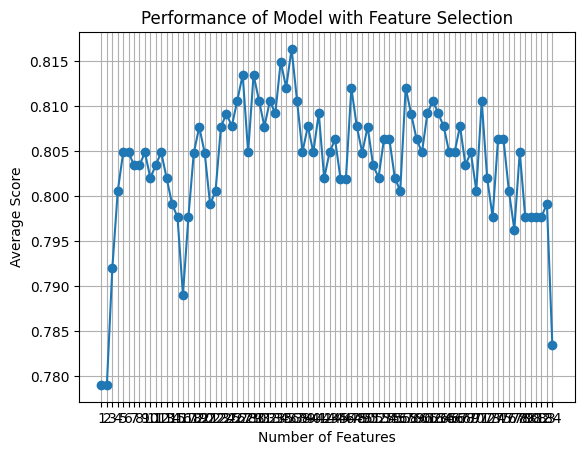

In [36]:
print("========================== Data 2  =================================")
slt_sbfs_features2_desb, score2_sbfs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SBFS', 5)
slt_sffs_features2_desb, score2_sffs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SFFS', 5)

### Avaliando os modelos com as features selecionadas

In [88]:
# Avaliando base 2 com sbfs
perform_cross_validation(modelo2_desb, X_train2.loc[:,slt_sbfs_features2_desb], y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.8264 (+/- 0.0566)
Class 0 - Precision: 0.7556, Recall: 0.5714, F1 Score: 0.6507
Class 1 - Precision: 0.8381, Recall: 0.7395, F1 Score: 0.7857
Class 2 - Precision: 0.8367, Recall: 0.9150, F1 Score: 0.8741


{'fit_time': array([0.06939411, 0.07090616, 0.06839323, 0.06839323, 0.07742143]),
 'score_time': array([0.01857781, 0.01857901, 0.01857781, 0.01857781, 0.01709771]),
 'test_score': array([0.83571429, 0.82857143, 0.78417266, 0.8705036 , 0.81294964])}

In [89]:
perform_cross_validation(modelo2_desb, X_train2.loc[:,slt_sffs_features2_desb], y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.8164 (+/- 0.0517)
Class 0 - Precision: 0.7356, Recall: 0.5378, F1 Score: 0.6214
Class 1 - Precision: 0.8632, Recall: 0.6891, F1 Score: 0.7664
Class 2 - Precision: 0.8214, Recall: 0.9216, F1 Score: 0.8686


{'fit_time': array([0.07291317, 0.07849789, 0.07749796, 0.07901478, 0.06874752]),
 'score_time': array([0.01764202, 0.01857805, 0.01857805, 0.01825213, 0.01778507]),
 'test_score': array([0.81428571, 0.80714286, 0.77697842, 0.85611511, 0.82733813])}

### Salvando as features selecionadas

#### Sem Random Under-Sampling

In [40]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features1_desb))
with open(f"results/SFFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sffs_features1_desb))


with open(f"results/SBFS_data2_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features2_desb))
with open(f"results/SFFS_data2_desb.txt", "w") as f:
    f.write(str(slt_sffs_features2_desb))

### [Abrir features selecionadas]

In [ ]:
# Lendo os arquivos txt com as features selecionadas
slt_sbfs_features1 = ler_arquivo_txt('results/SBFS_data1.txt')[0]
slt_sffs_features1 = ler_arquivo_txt('results/SFFS_data1.txt')[0]
slt_sbfs_features2 = ler_arquivo_txt('results/SBFS_data2.txt')[0]
slt_sffs_features2 = ler_arquivo_txt('results/SFFS_data2.txt')[0]

### Avaliando os modelos com as features selecionadas

In [71]:
# Função para pegar as features selecionadas do csv. Essa função retorna uma lista com as features selecionadas.
def get_features_selected(file):
    df = pd.read_csv(file)
    # Seleciona a linha da coluna avg_score que possui o maior valor
    df = df.loc[df['avg_score'] == df['avg_score'].max()]
    
    # Agora pega as features na coluna feature_idx
    features = df['feature_idx'].values[0]
    
    # Transforma a string em lista
    features = features.replace(' ', '').replace('(', '').replace(')', '').split(',')
    
    # Transforma os elementos da lista em inteiros
    features = [int(i) for i in features]
    
    return features

In [86]:
get_features_selected(r'results/SBFS_data2_desb.csv')

[11, 38, 45, 46, 52, 55, 60, 62, 66, 72, 74, 79, 81]

#### Sem Random Under-Sampling

In [ ]:
# Testando os modelos com as features selecionadas
print("========================== Data 1  - SBFS =================================")
perform_cross_validation(modelo1_desb, X_train1.loc[:,slt_sbfs_features1], x, 5, False)

print("========================== Data 1  - SFFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sffs_features1], target1_re, 5, False)

In [90]:
print("========================== Data 2  - SBFS =================================")
slt_sbfs_features2_desb = get_features_selected(r'results/SBFS_data2_desb.csv')
perform_cross_validation(modelo2_desb, X_train2.iloc[:,slt_sbfs_features2_desb], y_train2, 5, False)

# Acuracaria com dados de teste
modelo2_desb.fit(X_train2.iloc[:,slt_sbfs_features2_desb], y_train2)
pred = modelo2_desb.predict(X_test2.iloc[:,slt_sbfs_features2_desb])
print(f'Acurácia: {accuracy_score(y_test2, pred)}')

print("========================== Data 2  - SFFS =================================")
slt_sffs_features2_desb = get_features_selected(r'results/SFFS_data2_desb.csv')
perform_cross_validation(modelo2_desb, X_train2.iloc[:,slt_sffs_features2_desb], y_train2, 5, False)

# Acuracaria com dados de teste
modelo2_desb.fit(X_train2.iloc[:,slt_sffs_features2_desb], y_train2)
pred = modelo2_desb.predict(X_test2.iloc[:,slt_sffs_features2_desb])
print(f'Acurácia: {accuracy_score(y_test2, pred)}')

========================== Data 2  - SBFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.69       119
           1       0.85      0.66      0.75       119
           2       0.83      0.95      0.88       459

    accuracy                           0.83       697
   macro avg       0.85      0.73      0.77       697
weighted avg       0.84      0.83      0.83       697

--------------------------------------------------
Accuracy: 0.83
Acurácia: 0.7371428571428571
========================== Data 2  - SFFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63       119
           1       0.84      0.63      0.72       119
           2       0.81      0.95      0.87       459

    accuracy                           0.82       697
   macro avg       0.83      0.69     

## Matriz de Confusão

In [ ]:


# Definindo as classes
classes = ["Baixo", "Médio", "Alto"]

# Sua matriz de confusão de três classes
conf_matrix = np.array([[20, 0, 2],
                        [0, 30, 1],
                        [12, 3, 27]])

# Calculando precisão, recall e f1 score para cada classe
precision = []
recall = []
f1 = []

for i in range(len(conf_matrix)):
    TP = conf_matrix[i][i]
    FP = sum(conf_matrix[r][i] for r in range(len(conf_matrix)) if r != i)
    FN = sum(conf_matrix[i][c] for c in range(len(conf_matrix)) if c != i)

    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))
    f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))

# Criando um DataFrame com os resultados
df = pd.DataFrame({'Classe': classes, 'Precisão': precision, 'Recall': recall, 'F1 Score': f1})

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.xlabel('Classe Prevista', size=12, fontweight='bold')
plt.ylabel('Classe Real', size=12, fontweight='bold')
plt.title('Matriz de Confusão - SBFS - DATA 2', size=14, fontweight='bold')
plt.savefig('confusion_matrix_sbfs_data2.png', dpi=300, transparent=True)
plt.show()

# Exibindo a tabela com os resultados
print("Tabela de Resultados:")
df




In [17]:
# Decode the labels
decoded_labels = le.inverse_transform([0, 1, 2])

print(decoded_labels)


['Alto' 'Baixo' 'Medio']
